# Neural Networks for Time Series

In this notebook, we'll cover topics related to learning from time series and sequential data.

## Preamble

This lab session deals with the use of neural networks for time series classification and forecasting.
Two kinds of architectures are considered here: convolutional and recurrent models. An illustration of attention-based models is provided at the end of the lab.

## Time Series Classification using convolutional models (ConvNets)

For a start, you will load the "Trace" dataset using [`tslearn` data loading tool](https://tslearn.readthedocs.io/en/latest/gen_modules/datasets/tslearn.datasets.CachedDatasets.html#tslearn.datasets.CachedDatasets.load_dataset).

**Question #1.** What are the dimensions of the training data (`X_train`)? And what does each dimension correspond to (number of series, number of timestamps, number of features, ...)?
Also, `keras` expects class information to be encoded as one-hot vectors. Use [`to_categorical`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) to format your `y` arrays accordingly.


In [1]:
from tslearn.datasets import CachedDatasets
from keras.utils import to_categorical

data_loader = CachedDatasets()

X_train, y_train, X_test, y_test = data_loader.load_dataset("Trace")

y_train -= 1
y_test -= 1
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(X_train.shape, y_train.shape)

(100, 275, 1) (100, 4)


**Question #2.** In the following, you will be implementing a ConvNet using keras' [`Conv1D`](https://keras.io/api/layers/convolution_layers/convolution1d/) layers.
What value should be passed to the `data_format` parameter to match `tslearn` format? Is it the default value?

**Your Answer here.**

**Question #3.** `keras` has a `Sequential` model class that allows to build models by stacking layers.
Define a model that is made of the following layers (use ReLU activation wherever it makes sense):

* a convolution layer made of 10 filters of size 3
* a pooling layer of pool size 2
* a flatten layer (that converts a time series of features into a flattened array that is suited to feed fully-connected layers)
* a fully-connected layer that has as many neurons as the number of classes in the "Trace" problem, and an adequate activation function.

Compile your model (use "Adam" optimizer) and fit it for 10 epochs.

In [2]:
from keras.models import Sequential
from keras.layers import InputLayer, Conv1D, MaxPool1D, Flatten, Dense

model = Sequential([
    InputLayer(input_shape=(275, 1)),
    Conv1D(filters=10, kernel_size=3, activation="relu"),
    MaxPool1D(pool_size=2),
    Flatten(),
    Dense(units=4, activation="softmax")
])
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
h = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

Epoch 1/10


/Users/rtavenar/py3.10_ml/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
2024-02-04 17:49:26.205475: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-02-04 17:49:26.205493: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-02-04 17:49:26.205501: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-02-04 17:49:26.205532: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-04 17:49:26.205550: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefine

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.0133 - loss: 1.5980 - val_accuracy: 0.3100 - val_loss: 1.4041
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2344 - loss: 1.3783 - val_accuracy: 0.5000 - val_loss: 1.2299
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5660 - loss: 1.2031 - val_accuracy: 0.5800 - val_loss: 1.0923
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6098 - loss: 1.0675 - val_accuracy: 0.5900 - val_loss: 0.9871
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6483 - loss: 0.9618 - val_accuracy: 0.6000 - val_loss: 0.9116
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6810 - loss: 0.8830 - val_accuracy: 0.5800 - val_loss: 0.8546
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6602 - loss: 0.8200 - val_accuracy: 0.5400 - val_loss: 0.8117
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6587 - loss: 0.7746 - val_accuracy: 0.5500 - val_loss: 0.7805
Epoch 9/10

**Question #4.** Plot the evolution of accuracy through epochs on both training and validation sets.

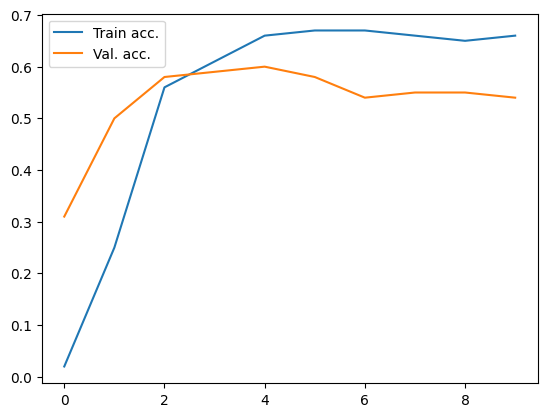

In [3]:
import matplotlib.pyplot as plt

plt.plot(h.history["accuracy"], label="Train acc.")
plt.plot(h.history["val_accuracy"], label="Val. acc.")
plt.legend();

**Question #5.** Ten epochs of training might not be sufficient, yet we do not know how many epochs would be necessary for a decent training. Set up early stopping (cf. [this callback](https://keras.io/api/callbacks/early_stopping/)) and see how long it takes before the model stops training.

In [4]:
from keras.callbacks import EarlyStopping

cb = EarlyStopping(patience=10, monitor="val_loss", restore_best_weights=True)

model = Sequential([
    InputLayer(input_shape=(275, 1)),
    Conv1D(filters=10, kernel_size=3, activation="relu"),
    MaxPool1D(pool_size=2),
    Flatten(),
    Dense(units=4, activation="softmax")
])
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
h = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=[cb])

Epoch 1/100


/Users/rtavenar/py3.10_ml/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.1950 - loss: 1.4848 - val_accuracy: 0.3900 - val_loss: 1.2991
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4985 - loss: 1.1954 - val_accuracy: 0.4000 - val_loss: 1.1001
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4977 - loss: 1.0153 - val_accuracy: 0.4100 - val_loss: 0.9600
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4806 - loss: 0.8988 - val_accuracy: 0.5000 - val_loss: 0.8687
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5875 - loss: 0.8114 - val_accuracy: 0.5100 - val_loss: 0.8095
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5979 - loss: 0.7550 - val_accuracy: 0.5200 - val_loss: 0.7617
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6298 - loss: 0.7171 - val_accuracy: 0.5200 - val_loss: 0.7303
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6787 - loss: 0.6901 - val_accuracy: 0.5400 - val_loss: 0.7115
Epo

## Recurrent neural nets

For this new part of the lab, we will use the data generated from the function below:

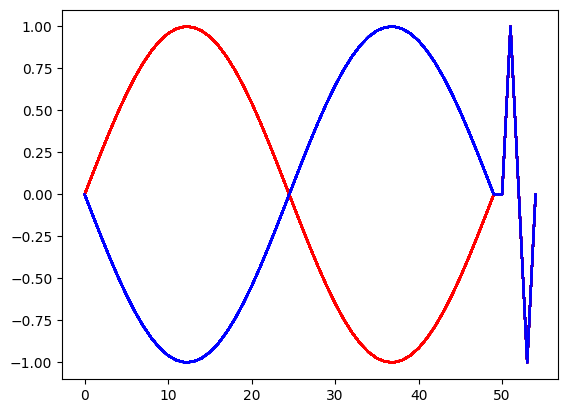

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def make_sines(n_series_per_class, length, length_padding=0):
    t = np.linspace(0, 2 * np.pi, num=length)
    X0 = .005 * np.random.randn(n_series_per_class, length + length_padding)
    X0[:, :length] = np.sin(t).reshape((1, -1))
    X0[:, length:] = np.sin(np.linspace(0, 2 * np.pi, num=length_padding))
    
    X1 = .005 * np.random.randn(n_series_per_class, length + length_padding)
    X1[:, :length] = np.sin(-t).reshape((1, -1))
    X1[:, length:] = np.sin(np.linspace(0, 2 * np.pi, num=length_padding))

    dataset = np.array([X0, X1]).reshape((2 * n_series_per_class, length + length_padding, 1))
    y = np.array([0] * n_series_per_class + [1] * n_series_per_class)

    indices = np.random.permutation(2 * n_series_per_class)
    return dataset[indices], y[indices]

np.random.seed(0)
X_train, y_train = make_sines(100, 50, length_padding=5)
X_test, y_test = make_sines(100, 50, length_padding=5)

plt.figure()
colors = ["r", "b"]
for ts, yi in zip(X_train, y_train):
    plt.plot(ts.ravel(), color=colors[yi])
plt.show()

**Question #7.** Implement your own recurrent layer (_cf._ formulas in the course) using the skeleton below and train a network
made of a single recurrent unit with a 8-dimensional hidden state followed by a fully connected layer, and evaluate its classification 
performance on the dataset provided above.

In [6]:
from keras.layers import Layer
from keras.ops import tanh, zeros

class CustomRecurrentUnit(Layer):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim

        # List sets of parameters here
        self.w_h = self.add_weight(
            shape=(hidden_dim, hidden_dim), initializer="random_normal", trainable=True
        )
        self.b_h = self.add_weight(shape=(hidden_dim,), initializer="zeros", trainable=True)
        self.w_i = self.add_weight(
            shape=(input_dim, hidden_dim), initializer="random_normal", trainable=True
        )
        self.b_i = self.add_weight(shape=(hidden_dim,), initializer="zeros", trainable=True)
    
    def linear_hidden(self, h_t):
        return h_t @ self.w_h + self.b_h
    
    def linear_input(self, x_t):
        return x_t @ self.w_i + self.b_i
    
    def call(self, x):
        n_timestamps = x.shape[1]
        h = zeros((1, self.hidden_dim))  # Initialize h to [0, ..., 0]
        for t in range(n_timestamps):
            h = tanh(self.linear_hidden(h) + self.linear_input(x[:, t, :]))
        return h

**Question #8.** Implement a network made of a `CustomRecurrentUnit` followed by a fully-connected layer
for the classification task introduced above.
Evaluate this model both in terms of training loss and test-set accuracy (you can use the above callback to limit the amount of logging).

In [7]:
model = Sequential([
    CustomRecurrentUnit(input_dim=1, hidden_dim=32),
    Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 507ms/step - accuracy: 0.4432 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.5336 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.5524 - loss: 0.6914 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.4895 - loss: 0.6942 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.4956 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.5232 - loss: 0.6923 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.5125 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.4984 - loss: 0.6936 - val_accuracy: 0.5000 - val_

**Question #9.** Update your dataset so that it includes a final padding of 15 timestamps (_cf._ signature of the `make_sines` function)
and see how it impacts performance of your model.

In [8]:
X_train, y_train = make_sines(100, 50, length_padding=15)
X_test, y_test = make_sines(100, 50, length_padding=15)

**Question #10.** Build GRU (resp. LSTM) counterparts of the RNN-based model above.
How do they compare experimentally to the previous model?

In [9]:
from keras.layers import GRU

model = Sequential([
    GRU(units=32),
    Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.4955 - loss: 0.6950 - val_accuracy: 0.4866 - val_loss: 0.6939
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5001 - loss: 0.6935 - val_accuracy: 0.4866 - val_loss: 0.6939
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4976 - loss: 0.6936 - val_accuracy: 0.4866 - val_loss: 0.6936
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4744 - loss: 0.6940 - val_accuracy: 0.4866 - val_loss: 0.6937
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5189 - loss: 0.6931 - val_accuracy: 0.4866 - val_loss: 0.6945
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5138 - loss: 0.6927 - val_accuracy: 0.4866 - val_loss: 0.6938
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5328 - loss: 0.6922 - val_accuracy: 0.4866 - val_loss: 0.6937
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5078 - loss: 0.6932 - val_accuracy: 0.4866 - val_loss

In [10]:
from keras.layers import LSTM

model = Sequential([
    LSTM(units=32),
    Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.5073 - loss: 0.6968 - val_accuracy: 0.5134 - val_loss: 0.6901
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4951 - loss: 0.6905 - val_accuracy: 0.5134 - val_loss: 0.6808
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4850 - loss: 0.6802 - val_accuracy: 1.0000 - val_loss: 0.6559
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.6429 - val_accuracy: 1.0000 - val_loss: 0.5754
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.5376 - val_accuracy: 1.0000 - val_loss: 0.4139
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.3689 - val_accuracy: 1.0000 - val_loss: 0.2404
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.2130 - val_accuracy: 1.0000 - val_loss: 0.1410
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.1243 - val_accuracy: 1.0000 - val_loss

In [11]:
model = Sequential([
    CustomRecurrentUnit(input_dim=1, hidden_dim=32),
    Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4932 - loss: 0.6935 - val_accuracy: 0.5134 - val_loss: 0.6931
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 295ms/step - accuracy: 0.4878 - loss: 0.6933 - val_accuracy: 0.4866 - val_loss: 0.6933
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - accuracy: 0.5205 - loss: 0.6930 - val_accuracy: 0.5134 - val_loss: 0.6931
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.4685 - loss: 0.6930 - val_accuracy: 0.5134 - val_loss: 0.6929
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.4673 - loss: 0.6939 - val_accuracy: 0.5134 - val_loss: 0.6928
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.4750 - loss: 0.6943 - val_accuracy: 0.5134 - val_loss: 0.6928
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.5083 - loss: 0.6931 - val_accuracy: 0.5134 - val_loss: 0.6928
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.4795 - loss: 0.6943 - val_accuracy: 0.5134 - val

## Recap

**Question #11.** Come back to the "Trace" dataset used above and design a fair comparison between several convolutional and recurrent architectures to decide which one to choose for the problem at hand (feel free to play with the depth of the nets, as well as hidden representation dimensionality, etc.).

In [12]:
data_loader = CachedDatasets()
X_train, y_train, X_test, y_test = data_loader.load_dataset("Trace")
print(X_train.shape)

y_train -= 1
y_test -= 1
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


feature_extractors = {
    "Conv_1layer": Sequential([
        Conv1D(filters=25, kernel_size=5, activation="relu")
    ]),
    "Conv_2layers": Sequential([
        Conv1D(filters=25, kernel_size=5, activation="relu"),
        Conv1D(filters=25, kernel_size=5, activation="relu"),
    ]),
    "Conv_3layers": Sequential([
        Conv1D(filters=25, kernel_size=5, activation="relu"),
        Conv1D(filters=25, kernel_size=5, activation="relu"),
        Conv1D(filters=25, kernel_size=5, activation="relu"),
    ]),
    "LSTM_1layer": Sequential([
        LSTM(units=25, return_sequences=True)
    ]),
    "LSTM_2layers": Sequential([
        LSTM(units=25, return_sequences=True),
        LSTM(units=25, return_sequences=True),
    ]),
    "LSTM_3layers": Sequential([
        LSTM(units=25, return_sequences=True),
        LSTM(units=25, return_sequences=True),
        LSTM(units=25, return_sequences=True)
    ]),
}

for name, f in feature_extractors.items():
    model = Sequential([
        f,
        Flatten(),
        Dense(units=4, activation="softmax")
    ])
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    h = model.fit(X_train, y_train, epochs=10, verbose=False)
    print(name, model.evaluate(X_test, y_test))

(100, 275, 1)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5120 - loss: 0.7073
Conv_1layer [0.6908024549484253, 0.5299999713897705]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6378 - loss: 0.6548
Conv_2layers [0.6783438324928284, 0.6700000166893005]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5921 - loss: 0.6131
Conv_3layers [0.6232718229293823, 0.6000000238418579]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5042 - loss: 0.8343
LSTM_1layer [0.878352165222168, 0.5]
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5358 - loss: 0.7430
LSTM_2layers [0.7611186504364014, 0.5400000214576721]
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.4976 - loss: 0.9245
LSTM_3layers [0.8633811473846436, 0.5199999809265137]


## Toy seq2seq task

We now turn our focus on attention-based models.
For a start, have a look at the data produced by the following `gen_data` function.
The task at hand is to predict the output sequence from its corresponding input one.

In [13]:
import numpy as np
import matplotlib.pyplot as plt


def make_series(positions, heights, shapes, size):
    series = np.zeros((size, ))
    for p, h, s in zip(positions, heights, shapes):
        if s == "r":
            series[p-5:p+5] = h
        else:
            series[p-5:p] = np.linspace(start=0., stop=h, num=5)
            series[p:p+5] = np.linspace(stop=0., start=h, num=5)
    return series.reshape((-1, 1))
    

def gen_data(n_samples, noise_level=.1):
    inputs, outputs = [], []
    shapes = np.array(["t", "r"] * 2)
    n_shapes = len(shapes)
    
    sz = 100
    region_width = sz // n_shapes
    
    for i in range(n_samples):
        np.random.shuffle(shapes)
        index_high_t = np.random.choice(np.where(shapes == "t")[0], size=1)[0]
        index_high_r = np.random.choice(np.where(shapes == "r")[0], size=1)[0]
        
        base_input_series = np.random.randn(sz, 1) * noise_level
        heights = []
        positions = []
        for idx_shape in range(n_shapes):
            pos = idx_shape * region_width + np.random.randint(low=5, high=region_width - 5)
            height = (.5 + np.random.rand(1)[0]) * 10.
            if idx_shape in [index_high_r, index_high_t]:
                height += 20.
            heights.append(height)
            positions.append(pos)
        input_series = np.random.randn(sz, 1) * noise_level + make_series(positions, heights, shapes, sz)
        
        normalized_heights = np.array(heights)
        for s in ["t", "r"]:
            normalized_heights[shapes == s] = normalized_heights[shapes == s].mean()
        output_series = np.random.randn(sz, 1) * noise_level + make_series(positions, normalized_heights, shapes, sz)
        inputs.append(input_series)
        outputs.append(output_series)
            
    return np.array(inputs), np.array(outputs)

np.random.seed(0)
inputs, outputs = gen_data(1000)
test_inputs, test_outputs = gen_data(10)

**Question #12.** Visualize the first 6 input/output pairs (each in one subfigure). Can you guess how the height of output motifs is computed?
Why would this data better suited to attention-based models than convolutional ones, for example?

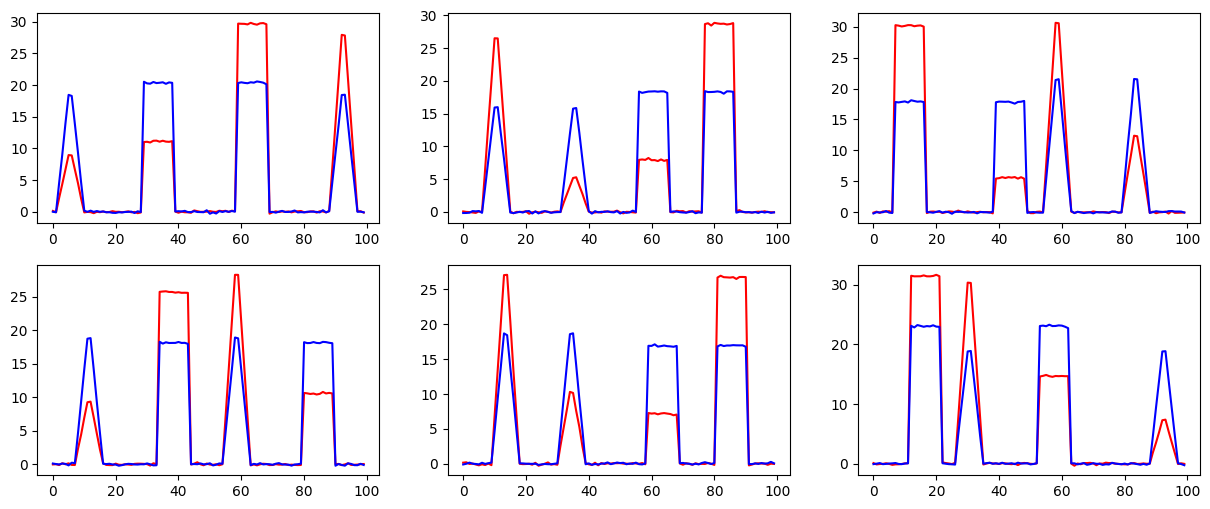

In [14]:
plt.figure(figsize=(15, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.plot(inputs[i, :, 0], color="r")
    plt.plot(outputs[i, :, 0], color="b")

**Question #13.** Check how a model made of a stack of 5 convolutional layers (use 64 filters in all layers except the last one) performs on this task. What loss function should you use?

In [15]:
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=5, padding="same", activation="relu"),
    Conv1D(filters=64, kernel_size=5, padding="same", activation="relu"),
    Conv1D(filters=64, kernel_size=5, padding="same", activation="relu"),
    Conv1D(filters=64, kernel_size=5, padding="same", activation="relu"),
    Conv1D(filters=1, kernel_size=5, padding="same", activation="relu"),
])
cnn_model.compile(loss="mse", optimizer="adam")
cnn_h = cnn_model.fit(inputs, outputs, validation_data=(test_inputs, test_outputs), epochs=20)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 48.5449 - val_loss: 24.1434
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 21.8565 - val_loss: 21.5061
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 18.1786 - val_loss: 9.1385
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.4420 - val_loss: 3.3496
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.1623 - val_loss: 1.9071
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.2294 - val_loss: 1.6253
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.1929 - val_loss: 2.1248
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.1142 - val_loss: 1.2338
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.9682 - val_loss: 1.6276
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.0020 - val_loss: 1.2186
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.9069 - val_loss: 1.2333
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - los

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


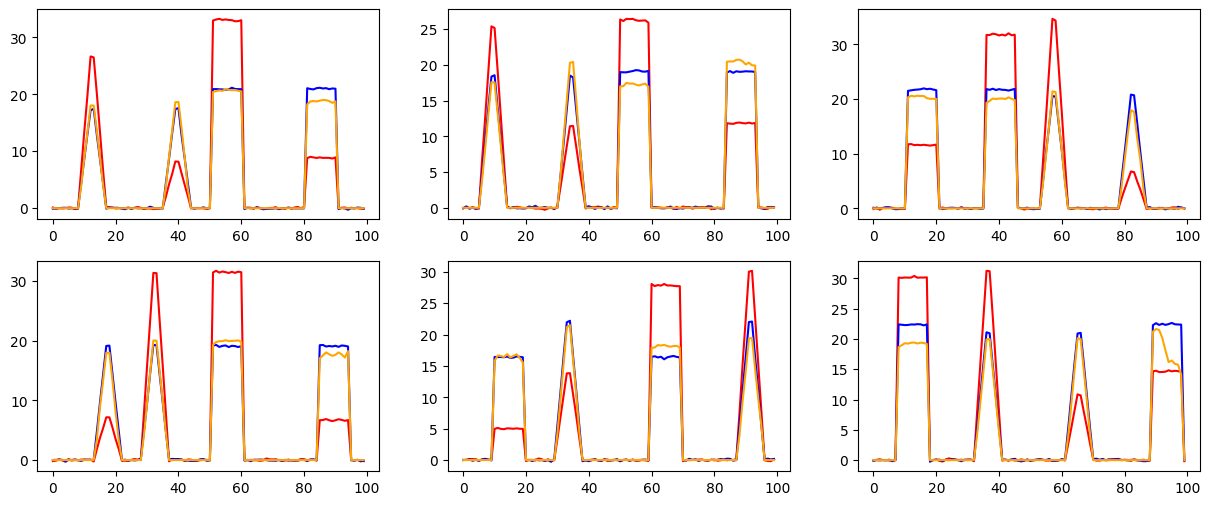

In [16]:
preds = cnn_model.predict(test_inputs)
plt.figure(figsize=(15, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.plot(test_inputs[i, :, 0], color="r")
    plt.plot(test_outputs[i, :, 0], color="b")
    plt.plot(preds[i, :, 0], color="orange")

**Question #14.** Below is the definition of a multi-head self attention layer class. Use this class to replace the 3rd convolution in your model above by a **single-head self-attention layer** that would output a 64-dimensional time series.

In [25]:
from keras.layers import MultiHeadAttention

class MultiHeadSelfAttention(MultiHeadAttention):
    def __init__(self, num_heads, key_dim, dropout=0.):
        super().__init__(num_heads, key_dim, dropout=dropout)

    def build(self, x_shape):
        super().build(query_shape=x_shape, key_shape=x_shape, value_shape=x_shape)

    def compute_output_shape(self, x_shape):
        return super().compute_output_shape(query_shape=x_shape, key_shape=x_shape, value_shape=x_shape)

    def call(self, x, return_attention_scores=False):
        return super().call(x, x, return_attention_scores=return_attention_scores)

In [27]:
attn_model = Sequential([
    Conv1D(filters=64, kernel_size=5, padding="same", activation="relu"),
    Conv1D(filters=64, kernel_size=5, padding="same", activation="relu"),
    MultiHeadSelfAttention(num_heads=1, key_dim=64),
    Conv1D(filters=64, kernel_size=5, padding="same", activation="relu"),
    Conv1D(filters=1, kernel_size=5, padding="same", activation="relu"),
])
attn_model.compile(loss="mse", optimizer="adam")
attn_h = attn_model.fit(inputs, outputs, validation_data=(test_inputs, test_outputs), epochs=20)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - loss: 64.2334 - val_loss: 8.1076
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 5.6289 - val_loss: 3.3085
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 3.2649 - val_loss: 2.5731
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 2.3520 - val_loss: 1.6150
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.5935 - val_loss: 1.5508
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.1836 - val_loss: 0.9106
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.9492 - val_loss: 1.0663
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.9509 - val_loss: 0.8135
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.8488 - val_loss: 0.7586
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.8312 - val_loss: 0.8202
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.9147 - val_loss: 0.8565
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0

**Question #15.** Compare both models in terms of validation loss.

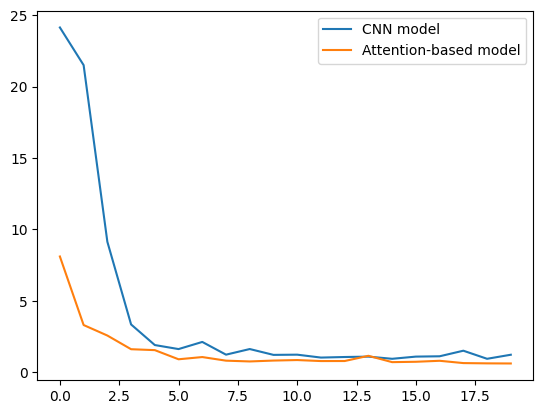

In [28]:
plt.plot(cnn_h.history["val_loss"], label="CNN model")
plt.plot(attn_h.history["val_loss"], label="Attention-based model")
plt.legend();

**Question #16.** Use test data for qualitative inspection of the produced outputs.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


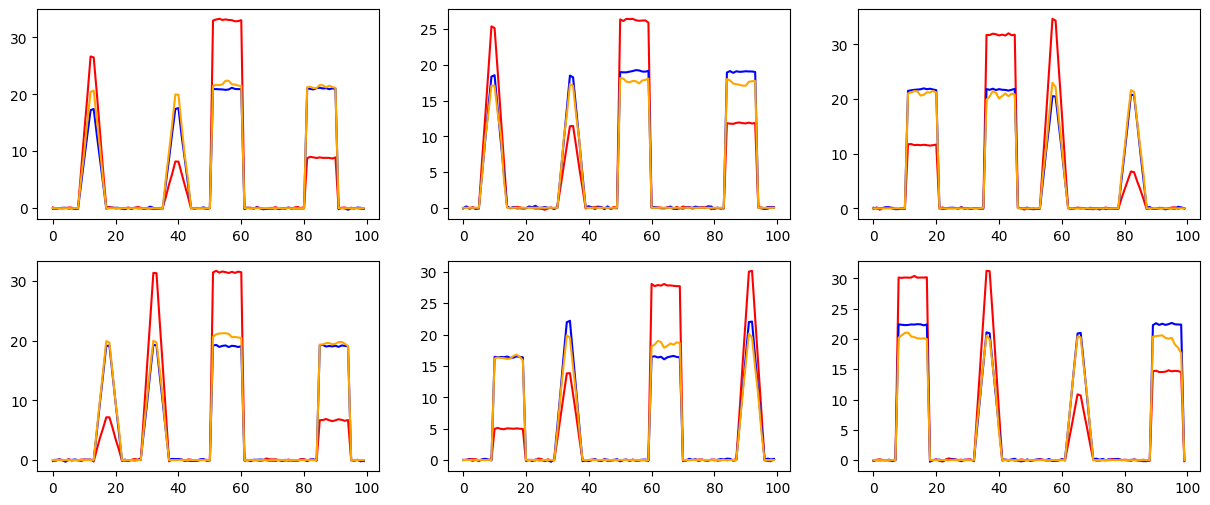

In [30]:
preds = attn_model.predict(test_inputs)
plt.figure(figsize=(15, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.plot(test_inputs[i, :, 0], color="r")
    plt.plot(test_outputs[i, :, 0], color="b")
    plt.plot(preds[i, :, 0], color="orange")

**Question #17.** Use the code below to visualize average attention scores for the first 3 test series.

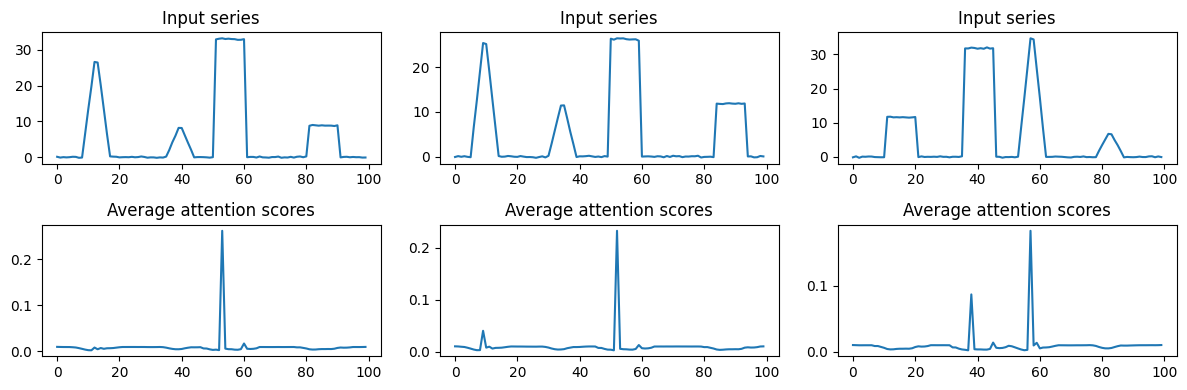

In [32]:
from keras.models import Sequential

def visualize_average_attention_scores(model, index_of_attention_layer, time_series):
    sub_model = Sequential(model.layers[:index_of_attention_layer])
    input_features = sub_model(time_series)
    att_layer = model.layers[index_of_attention_layer]
    _, weights = att_layer(input_features, return_attention_scores=True)

    plt.figure(figsize=(4*len(time_series), 4))
    for idx, ts in enumerate(time_series):
        plt.subplot(2, len(time_series), idx + 1)
        plt.plot(ts.ravel())
        plt.title("Input series")
        plt.subplot(2, len(time_series), len(time_series) + idx + 1)
        plt.plot(weights[idx, 0].numpy().mean(axis=0))
        plt.title("Average attention scores")
    plt.tight_layout()

visualize_average_attention_scores(attn_model, 2, test_inputs[:3])